0.0010001659393310547


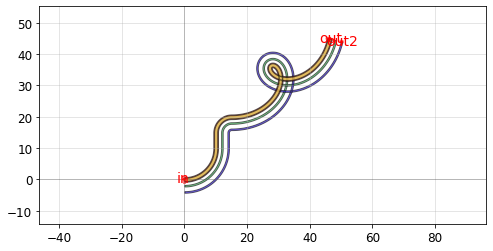

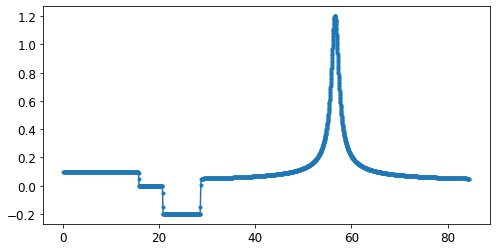

In [1]:
# This is a hidden cell which will be executed but will not show up in Sphinx docs.
# To hide a cell, in Jupyter go to Menu->View->Cell Toolbar->Edit Metadata
# and enter in {"nbsphinx": "hidden"}

# Set figure size and font size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['font.size'] = 12



import numpy as np
from matplotlib import pyplot as plt
from gdspy import clipper

from phidl.device_layout import _rotate_points
from phidl import Device, Layer, LayerSet, make_device
from phidl import quickplot as qp # Rename "quickplot()" to the easier "qp()"
import phidl.geometry as pg
import phidl.routing as pr
import phidl.utilities as pu
from gdspy import clipper
import time
from phidl.device_layout import _rotate_points


    
def looploop(t):
    """ Simple limacon loop-de-loop parametric curve, t goes from 0-1 """
    # t = (t-1)*np.pi
    r = 20 + 25*np.sin(t)
    x = r*np.cos(t)
    y = r*np.sin(t)
    return np.array((x,y))


def pp(points):
    plt.plot(points[:,0], points[:,1],'.--')
    # plt.gca().set_aspect('equal', 'box')
    



def arc(radius = 10, angle = 90, num_pts = 720):
    """ Produces an arc of points with `num_pts` per 360 degrees.  An extra point is
    tacked on each end to ensure that the numerical gradient is accurate """
    t = np.linspace(0, angle*np.pi/180, abs(int(num_pts*angle/360))-2)
    x = radius*np.cos(t)
    y = radius*np.sin(t)
    points = np.array((x,y)).T

    start_angle = 90*np.sign(angle)
    end_angle = start_angle + angle
    
    return points, start_angle, end_angle


def straight(length = 5):
    """ Produces a straight section """
    x = np.array([0,length])
    y = np.array([0,0])
    return np.array((x,y)).T

def straight(length = 5):
    """ Produces an straight section """
    x = np.linspace(0, length, 100)
    y = x*0
    return np.array((x,y)).T

#### Euler bends
# Taken from "Analysis of silicon nitride partial Euler waveguide bends"
# by Vogelbacher et. al. https://doi.org/10.1364/OE.27.031394

def cumtrapz(x):
    """ Numpy-based implementation of the cumulative trapezoidal integration 
    function usually found in scipy (scipy.integrate.cumtrapz) """
    return np.cumsum((x[1:] + x[:-1])/2)

def fresnel(R0, s, num_pts = 1000):
    t = np.linspace(0,s, num_pts)
    dt = t[1]-t[0]
    dxdt = np.cos(t**2/(2*R0**2))
    dydt = np.sin(t**2/(2*R0**2))
    x = cumtrapz(dxdt)*dt
    y = cumtrapz(dydt)*dt
    x = np.concatenate([[0], x])
    y = np.concatenate([[0], y])
    return x,y



def partial_euler(Reff = 3, a = 90, p = 0.2, num_pts = 1000, *args, **kwargs):
    η = kwargs.get('η', 1)
    j = kwargs.get('j', 0)
    if a <= 0 or a > 263: 
        raise ValueError("'a' must be a float such that 0 < a ≤ 263.")
    # Overhead calculations
    a     = np.radians(a)
    asp   = p * a / 2
    Rp    = 1 / 2 / np.sqrt(asp) * (j * Reff * η + 1 - j)
    sp    = np.sqrt(2 * asp)     * (j * Reff * η + 1 - j)
    s0    = 2 * sp + Rp * a * (1 - p)
    scale = a / (2 * sp * (s0 - sp))
    if p == 0: s0 = a * (j * Reff * η + 1 - j); scale = a / s0
    # Constructing s and K arrays
    s = np.linspace(0, s0, num_pts)
    K = np.zeros(num_pts)
    if p == 0: K += 1
    else:
        i1 = np.argmax(s > sp)
        i2 = np.argmax(s >= s0 - sp)
        K  = np.concatenate([np.multiply(np.ones(i1), 2 * s[:i1]),
                             np.multiply(np.ones(i2 - i1),2 * sp),
                             np.multiply(np.ones(num_pts - i2), 
                                                 2 * (s0 - s[i2:num_pts]))])
    K *= scale * ((1 - j) / Reff + j)
    s *= Reff  * (1 - j) + j
    # Integrating to find x and y
    ds = s[1] - s[0]
    φ = cumtrapz(K * ds)
    x = np.cumsum(ds * np.cos(φ))
    y = np.cumsum(ds * np.sin(φ))
    x = np.concatenate([[0], x])
    y = np.concatenate([[0], y])
    # Calculating η rescaling factor
    middle = int((num_pts - 1) / 2)
    η      = Reff / (y[middle] + x[middle] / np.tan(a / 2))
    if j == 1: return x, y
    else: return partial_euler(Reff, np.degrees(a), p, num_pts, η = η, j = 1)






def _simplify(points, epsilon=0):
    """ Ramer–Douglas–Peucker algorithm for line simplification.  Takes an
    array of points of shape (N,2) and removes excess points in the line. The
    remaining points form a identical line to within `epsilon` from the original """
    # From https://github.com/fhirschmann/rdp/issues/7 
    # originally written by Kirill Konevets https://github.com/kkonevets
    M = np.asarray(points)
    start, end = M[0], M[-1]
    dists = _line_dists(M, start, end)

    index = np.argmax(dists)
    dmax = dists[index]

    if dmax > epsilon:
        result1 = _simplify(M[:index + 1], epsilon)
        result2 = _simplify(M[index:], epsilon)

        result = np.vstack((result1[:-1], result2))
    else:
        result = np.array([start, end])

    return result


def _line_dists(points, start, end):
    if np.all(start == end):
        return np.linalg.norm(points - start, axis=1)

    vec = end - start
    cross = np.cross(vec, start - points)
    return np.divide(abs(cross), np.linalg.norm(vec))


class Path(object):
    def __init__(self, start_angle = 0):
        self.points = np.array([[0,0]])
        self.start_angle = start_angle
        self.end_angle = start_angle
        
    def append(self, points):
        
        if np.ndim(points) == 2: # Just a list of points
            start_angle = None
            end_angle = None
        elif np.ndim(points) == 1 and len(points) == 3: # (points, start_angle, end_angle)
            start_angle = points[1]
            end_angle = points[2]
            points = points[0]
        else:
            raise ValueError('[PHIDL] Path.append() must take arguments' + 
                ' of the form (points) or (points, start_angle, end_angle)')
        
        # Connect beginning of new points with old points
        if self.end_angle is None:
            nx1,ny1 =  self.points[-1] - self.points[-2]
            angle1 = np.arctan2(ny1,nx1)/np.pi*180
        else:
            angle1 = self.end_angle
        if start_angle is None:
            nx2,ny2 =  points[1] - points[0]
            angle2 = np.arctan2(ny2,nx2)/np.pi*180
        else:
            angle2 = start_angle
        points = _rotate_points(points, angle = angle1 - angle2)
        points += self.points[-1,:] - points[0,:]
        
        # Update end angle
        if end_angle is None:
            self.end_angle = None
        else:
            self.end_angle = end_angle + angle1 - angle2

        # Concatenate old points + new points
        self.points = np.vstack([self.points, points[1:]])
        return self


    def make(self, xsection, simplify = None):
        X = xsection
        
        D = Device()
        for s in X.segments:
            width = s['width']
            offset = s['offset']
            layer = s['layer']
            portnames = s['portnames']
            
            offset1 = offset + width/2
            offset2 = offset - width/2
            if offset1 > offset2:  offset1, offset2 = offset2, offset1
            
            points1 = self._parametric_offset_curve(self.points, offset_distance = offset + width/2,
                                    start_angle = self.start_angle, end_angle = self.end_angle)
            points2 = self._parametric_offset_curve(self.points, offset_distance = offset - width/2,
                                    start_angle = self.start_angle, end_angle = self.end_angle)
            
            # Simplify lines using the Ramer–Douglas–Peucker algorithm
            if isinstance(simplify, bool):
                raise ValueError('[PHIDL] the simplify argument must be a number (e.g. 1e-3) or None')
            if simplify is not None:
                points1 = _simplify(points1, epsilon = simplify)
                points2 = _simplify(points2, epsilon = simplify)
            
            # Join points together 
            points = np.concatenate([points1, points2[::-1,:]])

            # Combine the offset-lines into a polygon and union if join_after == True
            # if join_after == True: # Use clipper to perform a union operation
            #     points = np.array(clipper.offset([points], 0, 'miter', 2, int(1/simplify), 0)[0])
            
            D.add_polygon(points, layer = layer)
            
            # Add ports if they were specified
            if portnames[0] is not None:
                new_port = D.add_port(name = portnames[0])
                new_port.endpoints = (points1[0], points2[0])
            if portnames[1] is not None:
                new_port = D.add_port(name = portnames[1])
                new_port.endpoints = (points2[-1], points1[-1])
                
        return D

    def curvature(self):
        x = self.points[:,0]
        y = self.points[:,1]
        dx = np.diff(x)
        dy = np.diff(y)
        ds = np.sqrt((dx)**2 + (dy)**2)
        s = np.cumsum(ds)
        theta = np.arctan2(dy,dx)

        # Fix discontinuities arising from np.arctan2
        dtheta = np.diff(theta)
        dtheta[np.where(dtheta > np.pi)] += -2*np.pi
        dtheta[np.where(dtheta < -np.pi)] += 2*np.pi
        theta = np.concatenate([[0], np.cumsum(dtheta)]) + theta[0]

        K = np.gradient(theta,s, edge_order = 2)
        return s, K

    def _parametric_offset_curve(self, points, offset_distance, start_angle, end_angle):
        """ Creates a parametric offset (does not account for cusps etc)
        by using gradient of the supplied x and y points """
        x = points[:,0]
        y = points[:,1]
        dxdt = np.gradient(x)
        dydt = np.gradient(y)
        if start_angle is not None:
            dxdt[0] = np.cos(start_angle*np.pi/180)
            dydt[0] = np.sin(start_angle*np.pi/180)
        if end_angle is not None:
            dxdt[-1] = np.cos(end_angle*np.pi/180)
            dydt[-1] = np.sin(end_angle*np.pi/180)
        x_offset = x + offset_distance*dydt/np.sqrt(dxdt**2 + dydt**2)
        y_offset = y - offset_distance*dxdt/np.sqrt(dydt**2 + dxdt**2)
        return np.array([x_offset, y_offset]).T


class Xsection(object):
    def __init__(self): 
        self.segments = []
        self.portnames = set()
        
    def add(self, width = 1, offset = 0, layer = 0, portnames = (None,None)):
        if width <= 0:
            raise ValueError('[PHIDL] Xsection.add(): widths must be >0')
        if len(portnames) != 2:
            raise ValueError('[PHIDL] Xsection.add(): must receive 2 port names')
        for p in portnames:
            if p in self.portnames:
                raise ValueError('[PHIDL] Xsection.add(): portname "%s" already ' \
                                 "exists in this Xsection, please rename port" % p)

        new_segment = dict(
            width = width,
            offset = offset,
            layer = layer,
            portnames = portnames,
            )
        self.segments.append(new_segment)
        [self.portnames.add(p) for p in portnames if p is not None]
        
        return self
        



P = Path()
P.append( arc(radius = 10, angle = 90) )
P.append( straight())
P.append( arc(radius = 5, angle = -90) )
P.append( looploop(np.linspace(-np.pi,0,1000)).T )
# x,y = partial_euler()
# P.append( np.array([x,y]).T )



# P = Path()
# num_pts = 1000
# P.append( arc(radius = 10, angle = 90, num_pts = num_pts) )
# P.append( arc(radius = 5, angle = -90, num_pts = num_pts) )

X = Xsection()
X.add(width = 0.5, offset = 2, layer = 0, portnames = [None,None])
X.add(width = 0.5, offset = 4, layer = 1, portnames = [None,'out2'])
X.add(width = 1.5, offset = 0, layer = 2, portnames = ['in','out'])
X.add(width = 1, offset = 0, layer = 3)

t = time.time()
for n in range(1):
    D = P.make(xsection = X, simplify = None)
print((time.time()-t))
# print('hello')
qp(D)
D.write_gds('hello.gds', precision = 1e-12)

s,K = P.curvature()
plt.plot(s,K,'.-')

# pp(P.points)
# x,y = partial_euler(Reff = 3, a = 180, p = 0.2, num_pts = 4000)
# pp(np.array([x,y]).T)


# Paths and waveguides

[PHIDL](https://github.com/amccaugh/phidl) includes an extremely efficient module for creating smooth curves, particularly useful for creating waveguide structures such as those used in photonics.   There are two components to creating a path: (1) specify the points you want the path to follow, and (2) specify what you want the path cross-section to look like. Creating a path device is simple

- Create a blank `Path`
- Append points to the `Path` either using the built-in functions (`arc`, `euler_bend`, `straight`) or by providing your own lists of points
- Specify what you want the cross-section (`Xsection`) to look like
- Combine the `Path` and the `Xsection` to make the polygons inside a `Device`

## Path creation

The first step is to generate the list of points we want the path to follow.  Let's start out by creating a blank `Path` and using the built-in functions to make a few turns.

In [2]:
P = Path()
P.append( arc(radius = 10, angle = 90) )
P.append( straight(length = 10) )
P.append( arc(radius = 5, angle = -90) )
P.append( straight(length = 40) )
P.append( arc(radius = 8, angle = -45) )
P.append( straight(length = 10) )
P.append( arc(radius = 8, angle = 45) )
P.append( straight(length = 10) )

So far, all we've done is added points together.  If we examine our new path `P` we can see that all we've simply created long list of points:

(925, 2)


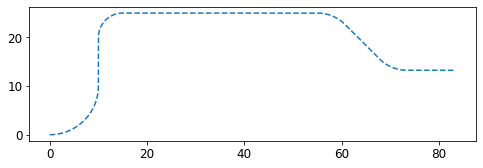

In [3]:
path_points = P.points # The points are stored as a numpy array in P.points
print(np.shape( P.points ) ) # The shape of the array is Nx2

# Let's plot the points 
import matplotlib.pyplot as plt
plt.plot(path_points[:,0], path_points[:,1],'--')
# Set the axes aspect ratio to be equal
plt.gca().set_aspect('equal', 'box')

## Defining the cross-section

Now that we've got our path defined, the next step is to tell phidl what we want the cross-section of the path to look like.  To do this, we create a blank `Xsection` and add whatever cross-sections we want to it.  We can then combine the `Path` and the `Xsection` using the `make()` function to generate our final geometry:

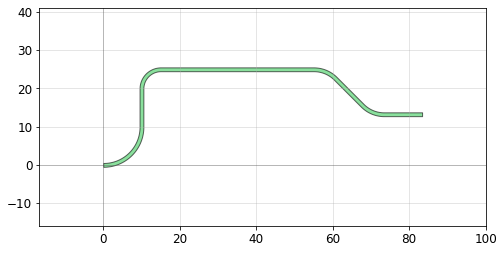

In [4]:
# Create a blank Xsection
X = Xsection()

# Add a single "section" to the cross-section
X.add(width = 1, offset = 0, layer = 0)

# Combine the Path and the Xsection
waveguide_device = P.make(xsection = X)

# Quickplot the resulting Device
qp(waveguide_device)

Now, what if we want a more complicated waveguide?  For instance, in some photonic applications it's helpful to have a shallow etch that appears on either side of the waveguide (often called a "sleeve).  Additionally, it might be nice to have a Port on either end so we can snap other geometries to it.  Let's try adding something like that in:

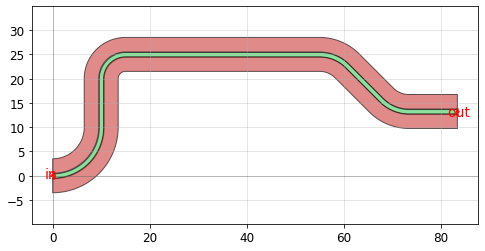

In [5]:
# Create a blank Xsection
X = Xsection()

# Add a single "section" to the cross-section
X.add(width = 1, offset = 0, layer = 0, portnames = ('in','out'))
X.add(width = 3, offset = 2, layer = 2)
X.add(width = 3, offset = -2, layer = 2)

# Combine the Path and the Xsection
waveguide_device = P.make(xsection = X)

# Quickplot the resulting Device
qp(waveguide_device)

## Custom curves

Now let's have some fun and try to make a loop-de-loop structure with parallel waveguides and several Ports. 

To create a new type of curve we simply make a function that produces an array of points.  The best way to do that is to create a function which allows you to specify a large number of points along that curve -- in the case below, the `looploop()` function outputs 1000 points along a looping path.  Later, if we want reduce the number of points in our geometry we can trivially `simplify` the path.

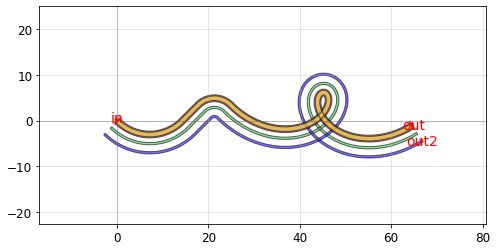

In [6]:
def looploop(num_pts = 1000):
    """ Simple limacon looping curve """
    t = np.linspace(-np.pi,0,num_pts)
    r = 20 + 25*np.sin(t)
    x = r*np.cos(t)
    y = r*np.sin(t)
    points = np.array((x,y)).T
    return points

# Create the path points
P = Path(start_angle = -45)  # Start out with a path at -45 degrees
P.append( arc(radius = 10, angle = 90) )
P.append( straight())
P.append( arc(radius = 5, angle = -90) )
P.append( looploop(num_pts = 1000) )

# Create the crosssection
X = Xsection()
X.add(width = 0.5, offset = 2, layer = 0, portnames = [None,None])
X.add(width = 0.5, offset = 4, layer = 1, portnames = [None,'out2'])
X.add(width = 1.5, offset = 0, layer = 2, portnames = ['in','out'])
X.add(width = 1, offset = 0, layer = 3)

D = P.make(xsection = X)
qp(D) # quickplot the resulting Device

## Simplifying / reducing point usage

One of the chief concerns of generating smooth curves is that too many points are generated, inflating file sizes and making boolean operations computationally expensive.  Fortunately, PHIDL has a fast implementation of the [Ramer-Douglas–Peucker algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm) that lets you reduce the number of points in a curve without changing its shape.  All that needs to be done is when you `make()` the device, you specify the `simplify` argument.

If we specify `simplify = 1e-3`, the number of points in the line drops from 12,000 to 4,000, and the remaining points form a line that is identical to within `1e-3` distance from the original:

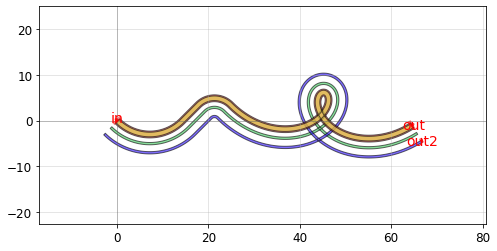

In [7]:
# The remaining points form a identical line to within `1e-3` from the original
D = P.make(xsection = X, simplify = 1e-3)
qp(D) # quickplot the resulting Device

Let's say we need fewer points.  We can increase the simplify tolerance by specifying `simplify = 1e-1`.  This drops the number of points to ~400 points form a line that is identical to within `1e-1` distance from the original:

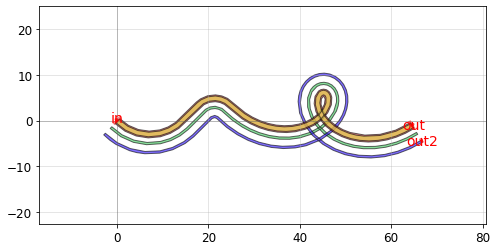

(380, 2)


In [8]:
D = P.make(xsection = X, simplify = 1e-1)
qp(D) # quickplot the resulting Device

# Compute the number of points in the shape
print(np.vstack(D.get_polygons()).shape)

Taken to absurdity, what happens if we set `simplify = 0.3`?  Once again, the ~200 remaining points form a line that is within `0.3` units from the original -- but that line looks pretty bad.  

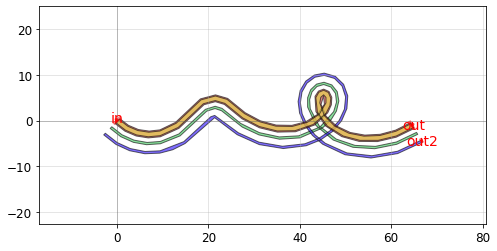

In [9]:
D = P.make(xsection = X, simplify = 0.3)
qp(D) # quickplot the resulting Device

## Curvature calculation

The `Path` class has a `curvature()` method that computes the curvature of your path.  This can be helpful for guaranteeing your curves transition smoothly such as in [track-transition curves](https://en.wikipedia.org/wiki/Track_transition_curve) (also known as clothoid or euler curves in the photonics world).  Note this curvature is numerically computed so it is only approximate, and areas where the curvature jumps instantaenously (such as between an arc and a straight segment) will be slightly interpolated.

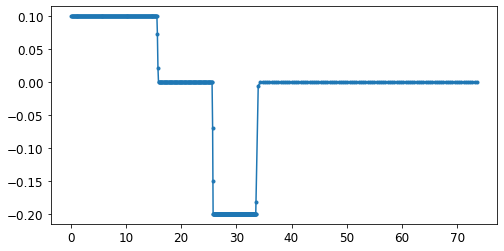

In [10]:
P = Path()
P.append( arc(radius = 10, angle = 90) ) # Should have a curvature of 1/10
P.append( straight(length = 10) )        # Should have a curvature of 0
P.append( arc(radius = 5, angle = -90) ) # Should have a curvature of -1/5
P.append( straight(length = 40) )        # Should have a curvature of 0

s,K = P.curvature()
plt.plot(s,K,'.-')